# Rapport E1, Étude

## Fonctions et import

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import sqlite3

import random

from joblib import dump, load

import datetime
from datetime import date, timedelta
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline

#from sklearn.metrics import accuracy_score, classification_report, r2_score
#from tensorflow import keras

import seaborn as sn
import matplotlib.pyplot as plt
# Pour utiliser le module inline 'module://matplotlib_inline.backend_inline'
#  D'autre backend peuvent être utilisée
%matplotlib inline

In [8]:
s= "5-11-1965"
d= datetime.datetime.strptime(s,'%d-%m-%Y')
d

datetime.datetime(1965, 11, 5, 0, 0)

In [10]:
da=date.today()
da

datetime.date(2022, 4, 18)

In [11]:
date(da.year, da.month,da.day)

datetime.date(2022, 4, 18)

In [2]:
class Faussaire:
    _prenoms_csv= "datas/Prenoms.csv"
    _filtre_prenoms= 1
    _noms_csv= "datas/patronymes.csv"
    _freq_nom= 120
    __liste_prenoms_courant_homme= None
    __liste_prenoms_courant_femme= None
    __liste_noms_filtre= None
    __prenoms= None
    __noms= None
    __long_liste_fem= 0
    __long_liste_hom= 0
    __long_liste_nom= 0
    
    def __init__(self):
        # Prénoms h et f
        self.__prenoms= pd.read_csv(self._prenoms_csv, sep= ';', encoding="latin1") #, encoding="latin1"
        prenoms_courant= self.__prenoms[self.__prenoms["04_fréquence"] > self._filtre_prenoms]

        prenoms_courant_femme= prenoms_courant[ (prenoms_courant["02_genre"]== "f") | 
                                              (prenoms_courant["02_genre"]== 'm,f') |
                                              (prenoms_courant["02_genre"]== 'f,m')]
        self.__liste_prenoms_courant_femme= list(prenoms_courant_femme["01_prenom"])
        self.__long_liste_fem= len(self.__liste_prenoms_courant_femme)


        prenoms_courant_homme= prenoms_courant[ (prenoms_courant["02_genre"]== "m") |
                                              (prenoms_courant["02_genre"]== 'm,f') |
                                              (prenoms_courant["02_genre"]== 'f,m')]
        self.__liste_prenoms_courant_homme= list(prenoms_courant_homme["01_prenom"])
        self.__long_liste_hom= len(self.__liste_prenoms_courant_homme)
        
        # Noms
        self.__noms= pd.read_csv(self._noms_csv)
        noms_filtre= self.__noms[self.__noms["count"]>self._freq_nom]
        self.__liste_noms_filtre= list(noms_filtre["patronyme"])
        self.__long_liste_nom= len(self.__liste_noms_filtre)

    def nom_prenom(self, genre= None):
        assert genre== 'f' or genre== 'h', "ERREUR de valeur: Le genre doît être 'f' ou 'h'"

        #try:
        i= random.randint(0, self.__long_liste_nom - 1)
        nom= self.__liste_noms_filtre[i]

        if genre== 'f':
            j= random.randint(0, self.__long_liste_fem - 1)
            prenom= self.__liste_prenoms_courant_femme[j]
        else:
            j= random.randint(0, self.__long_liste_hom - 1)
            prenom= self.__liste_prenoms_courant_homme[j]

        return  nom, prenom#, len(self.__liste_noms_filtre)
    
    def voir_nom_i(self, i):
        return self.__liste_noms_filtre[i]
    
    def voir_df_noms(self):
        return self.__noms
        
    def voir_df_prenoms(self):
        return self.__prenoms


In [3]:
def erreur_prediction(valeurs_predites= None, valeurs_reelle= None):
    """
    Vérifie que les valeurs prédites sont les mêmes que les valeurs réelles.
    
    paramètres en entrée:
    valeurs_predites
    valeurs_reelle
    
    Paramètres de sortie:
    erreur: nombre d'erreur de prédiction
    precision: 100*(1-erreur/(longueur des tableaux)
    liste_erreur: Liste de toutes les erreurs détecté sous forme de dictionnaire 
        clé valeur réelle: valeur prédite
    """
    
    assert len(valeurs_predites) == len(valeurs_reelle), "Erreur de dimension: la dimension des tableaux "+\
        f"doit être identique. {len(valeurs_predites)} # de {len(valeurs_reelle)}"

    erreur= 0
    d= {}
    longueur= len(valeurs_reelle)
    for i in range(longueur):
        if valeurs_reelle[i]!= valeurs_predites[i]:
            if valeurs_reelle[i] not in d.keys():
                d[valeurs_reelle[i]]= [valeurs_predites[i]]
            else:
                d[valeurs_reelle[i]].append(valeurs_predites[i])
            erreur+= 1
        
    return erreur, 100*(1-erreur/longueur), d


In [4]:
def test_algo(modele= None, standardisation= None, Xtrain= None, Ytrain= None, Xtest= None, Ytest= None):
    model= modele
    if standardisation!= None:
        Xtrain_normalise= standardisation.fit_transform(X_train)
        X_test_normalise= standardisation.transform(X_test)
    else:
        Xtrain_normalise= Xtrain
        X_test_normalise= Xtest
        
    model.fit(Xtrain_normalise, Ytrain)
    
    return model.score(X_test_normalise,Ytest)

## Importation des données
Pour étudier le contenu du dataset, on va supprimer la colonne id et rajouter une colonne IMC pour traquer les valeur abérantes.

In [260]:
df= pd.read_csv("./datas/cardio_train.csv",sep= ";", index_col= "id")

# Création de l'IMC qui nous servira pour la détection de valeurs aberrantes
df["IMC"]= df.weight/((df.height/100)**2)

df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676
9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725
12,22584,2,178,95.0,130,90,3,3,0,0,1,1,29.983588
13,17668,1,158,71.0,110,70,1,1,0,0,1,0,28.440955


In [12]:
analyse= ProfileReport(df)
analyse.to_file(output_file="cardio.html")

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Recherche d'éventuel doublon

In [261]:
len(df[df.duplicated(subset=['age', 'gender','height', 'weight', 'ap_hi', 'ap_lo',
                            'cholesterol','gluc', 'smoke', 'alco', 'active','cardio'])== True])

24

In [262]:
df[df.duplicated(subset=['age', 'gender','height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol','gluc',
                         'smoke', 'alco', 'active','cardio'], keep= False)== True].sort_values(by = ['age'])

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
id,,,,,,,,,,,,,
57690,14552,1,158,64.0,120,80,1,1,0,0,1,0,25.636917
9004,14552,1,158,64.0,120,80,1,1,0,0,1,0,25.636917
91592,16160,1,168,65.0,120,80,1,1,0,0,1,1,23.030045
24435,16160,1,168,65.0,120,80,1,1,0,0,1,1,23.030045
1685,16793,1,165,68.0,120,80,1,1,0,0,1,0,24.977043
31110,16793,1,165,68.0,120,80,1,1,0,0,1,0,24.977043
40450,16805,1,157,67.0,120,80,1,1,0,0,1,0,27.181630
86345,16805,1,157,67.0,120,80,1,1,0,0,1,0,27.181630
63776,16937,2,170,70.0,120,80,1,1,0,0,0,0,24.221453


In [263]:
# Suppression des doublons
df.drop_duplicates(subset= ['age', 'gender','height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol','gluc',
                         'smoke', 'alco', 'active','cardio'], keep= 'first', inplace= True)

In [265]:
cte_age_an_jour= 365.242199
print(f"Dans ce jeu de donnée, le patient le plus jeune à {int(10798/cte_age_an_jour)} ans et le "+\
      f"plus âgé {int(23713/cte_age_an_jour)} ans avec une moyenne d'âge de {int(19468/cte_age_an_jour)} ans.")

Dans ce jeu de donnée, le patient le plus jeune à 29 ans et le plus âgé 64 ans avec une moyenne d'âge de 53 ans.


### Recherche de valeurs abbérantes:  
Il y a un certains nombre de valeurs abbérantes qu'il convient de traiter.  
Exemple:  
* Enregistrement 9223, âge 21220, genre 1, taille 250
* Enregistrement 82567, âge 18804, genre 2, poids 10.0 pression artérielle 180/1100
* Enregistrement 11089, pression artérielle 11500
* Enregistrement 22108, pression artérielle négative (-115)
  
On va supprimer ces enregistrements
  
Pour supprimer les valeur abbérantes poids / taille on créer la colonne IMC.  

|IMC 	|Interprétation|
|-------|--------------|
|+ de 40|obésité morbide ou massive|
|35 à 40|obésité sévère|
|30 à 35|obésité modérée|
|25 à 30|surpoids|
|18.5 à 25|corpulence normale|
|16.5 à 18.5|maigreur|
|- de 16.5|famine|


In [266]:
df[ (df.IMC>40)&(df.cardio== 0)&(df.active== 0)]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
id,,,,,,,,,,,,,
618,16765,1,186,200.0,130,70,1,1,0,0,0,0,57.810151
846,14705,1,164,125.0,130,90,1,1,0,0,0,0,46.475312
1378,21897,1,154,110.0,110,70,1,1,0,0,0,0,46.382189
1721,15126,2,173,125.0,120,80,1,1,1,0,0,0,41.765512
1965,22644,1,166,131.0,120,80,3,3,0,0,0,0,47.539556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87816,17375,1,162,110.0,110,60,1,3,0,0,0,0,41.914342
89887,17325,1,165,115.0,120,80,1,1,0,0,0,0,42.240588
91523,18426,1,59,57.6,125,67,1,1,0,0,0,0,165.469693


In [267]:
df[ (df.IMC<15)&(df.cardio== 0)&(df.active== 0) ]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
id,,,,,,,,,,,,,
31869,21228,1,169,42.0,150,90,2,2,0,0,0,0,14.705367
90183,22192,2,198,58.0,110,70,1,1,0,0,0,0,14.794409


In [268]:
df[ (df.ap_hi<5)|(df.ap_hi>300) ]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
id,,,,,,,,,,,,,
2654,15116,1,160,60.0,902,60,1,1,0,0,1,0,23.437500
2845,22712,2,167,59.0,906,0,1,1,0,0,1,0,21.155294
6525,15281,1,165,78.0,-100,80,2,1,0,0,1,0,28.650138
6822,14425,1,168,63.0,909,60,2,1,0,0,1,0,22.321429
11089,21032,1,175,80.0,11500,90,1,1,0,0,1,1,26.122449
12494,16905,2,163,63.0,1,2088,1,1,1,0,1,0,23.711845
12710,18870,1,164,75.0,1420,80,2,1,0,0,1,1,27.885187
13616,22659,1,155,87.0,701,110,1,1,0,0,1,1,36.212279
19827,15996,1,168,72.0,1500,80,1,1,0,0,1,1,25.510204


In [269]:
df[ (df.ap_lo<2)|(df.ap_lo>300) ]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,IMC
id,,,,,,,,,,,,,
314,17489,2,183,98.0,160,1100,1,2,1,0,1,1,29.263340
334,21932,2,157,60.0,160,1000,2,1,0,0,0,1,24.341758
357,18217,1,150,83.0,140,800,1,1,0,0,1,1,36.888889
458,23407,1,176,63.0,160,1000,2,2,0,0,0,1,20.338326
482,18704,1,154,81.0,140,1000,2,1,0,0,1,1,34.154158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99659,23330,1,167,81.0,160,1000,1,1,0,0,1,1,29.043709
99798,21808,1,152,56.0,160,1000,1,1,0,0,1,1,24.238227
99807,21239,2,168,95.0,160,1000,1,1,0,0,1,1,33.659297


### Enregistrement du dataset sans les doublons

In [270]:
df.to_csv("prov.csv", encoding= "utf-8", sep=",", index= False)

## Création d'une base de donnée analytique
### On va créer une base de données qui contiendra toute les données filtrées du dataset

In [272]:
bd= 'base_E1_train.db'
# Ne pas ré-exécuter ce code une fois la base créée
"""
try:
    # Création de la base de donnée
    conn = sqlite3.connect(bd)
    print(f"Création de la base {bd} réussi")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

Création de la base base_E1_train.db réussi


In [273]:
# Ne pas ré-exécuter ce code une fois la base créée - Création de la table entraînement
"""
try:
    conn = sqlite3.connect(bd)
    cur = conn.cursor()
    
    sql = "CREATE TABLE entrainement ( "+\
            "id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "+\
            "age INTEGER NOT NULL, "+\
            "gender INTEGER, "+\
            "height INTEGER NOT NULL, "+\
            "weight INTEGER NOT NULL, "+\
            "ap_hi INTEGER NOT NULL, "+\
            "ap_lo INTEGER NOT NULL, "+\
            "cholesterol INTEGER, "+\
            "gluc INTEGER, "+\
            "smoke INTEGER, "+\
            "alco INTEGER, "+\
            "active INTEGER, "+\
            "cardio INTEGER );"
    cur.execute(sql)
    conn.commit()
    cur.close()
    conn.close()
    print("Table créée.")

except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

Table créée.


### Filtrage des données

In [274]:
df= pd.read_csv("prov.csv")

# Suppression de valeur abbérante IMC
# On supprime les IMC>40 qui ne font pas de sport et noté sans risque cardio
df= df[ (df.IMC<40)|(df.cardio== 1)|(df.active== 1) ]
# On supprime les IMC<15 qui ne font pas de sport et noté sans risque cardio
df= df[ (df.IMC>15)|(df.cardio== 1)|(df.active== 1) ]

# suppression valeurs abbérantes des pressions artérielles
df= df[ (df.ap_hi>5)&(df.ap_hi<300) ]
df= df[ (df.ap_lo>2)&(df.ap_lo<300) ]

# suppression de la colonne IMC qui n'appartient pas au dataset original
df.drop("IMC", axis= 1, inplace= True)


### Intégrations des données dans la table entrainement de la base créée

In [275]:
# Ne pas ré-exécuter ce code une fois la table rempli
"""
try:
    # Création de la base de donnée
    conn = sqlite3.connect(bd)
    cur = conn.cursor()

    sql = "INSERT INTO entrainement (age, gender, height, weight, ap_hi, ap_lo, cholesterol, "+\
        "gluc, smoke, alco, active, cardio) VALUES(?,?,?,?,?,?,?,?,?,?,?,?)"
    
    for i, row in df.iterrows():
        cur.execute(sql, tuple(row))
        conn.commit()

    cur.close()
    conn.close()
    print("La connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

La connexion SQLite est fermée


## Création d'une base de donnée de production
### On va créer une base de données qui contiendra plusieurs tables
- Table patient
- Table médecin
- Table examens

In [71]:
bdp= 'base_E1.db'
# Ne pas ré-exécuter ce code une fois la base créée
"""
try:
    # Création de la base de donnée
    conn = sqlite3.connect(bd)
    print(f"Création de la base {bd} réussi")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

Création de la base base_E1.db réussi


#### Table des patients

In [254]:
# Ne pas ré-exécuter ce code une fois la base créée - Création de la table patient
"""
try:
    conn = sqlite3.connect(bdp)
    cur = conn.cursor()
    
    sql = "CREATE TABLE patient ( "+\
            "idp INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "+\
            "nom TEXT NOT NULL, "+\
            "prenom TEXT NOT NULL, "+\
            "naissance TEXT NOT NULL);"
    
    cur.execute(sql)
    conn.commit()
    cur.close()
    conn.close()
    print("Table créée.")

except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

Table créée.


In [248]:
# On inclu dans la base les patients, les id de médecin, et la colonne diag_conf
df=df.reset_index(drop= True)

df["nom"]= ""
df["prenom"]= ""
df["idp"]= 0
df["idmed"]= 0
df["diag_conf"]= 1 # On suppose que tout les diagnostiques dans la base sont confirmées

for idx, row in df.iterrows():   
    #Seul l'id du médecin figurera dans la table examen
    df.loc[idx,"idmed"]= random.randint(0, len(liste_medecin)-1)
    
    # future clé primaire de la table patient
    df.loc[idx,"idp"]= idx +1

    # Calcul de la date de naissance. On suppose que l'âge donnée dans la table
    #  correspond à l'âge du patien au jour de l'examen. On ajoute à ce nombre de
    #  jours un nombre aléatoire et on en "déduit" une date de naissance....
    # Même si seul "idp" appartiendra à la table d'examen, on est obligé d'inclure
    #  les noms prénoms et date de naissance de façon provisoire dans cette table
    ecart= random.randint(10,1000)
    age= int(df.loc[idx,"age"])
    dt= date.today()-timedelta(days= age + ecart)
    df.loc[idx,"naissance"]= pd.to_datetime(dt)
    
    # Nom et prénom (en fonction du sexe) du patient
    if df.loc[idx,"gender"]== 1:
        nom, prenom= faux_et_usage_de_faux.nom_prenom('h')
        df.loc[idx,"nom"]= nom
        df.loc[idx,"prenom"]= prenom
    else:
        nom, prenom= faux_et_usage_de_faux.nom_prenom('f')
        df.loc[idx,"nom"]= nom
        df.loc[idx,"prenom"]= prenom


In [255]:
# df pour créer la table patient
df_patient= df.drop(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'idmed', 'diag_conf'],axis= 1)


In [256]:
# Ne pas ré-exécuter ce code une fois la base créée - Remplissage de la table patient
"""
try:
    # Création de la base de donnée
    conn = sqlite3.connect(bdp)
    cur = conn.cursor()

    sql = "INSERT INTO patient(nom,prenom,idp,naissance) VALUES(?,?,?,?)"
    
    for i, row in df_patient.iterrows():
        l= tuple(row)
        cur.execute(sql, (l[0],l[1],l[2],str(l[3])))
        conn.commit()


    cur.close()
    conn.close()
    print("La connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

La connexion SQLite est fermée


#### Table des médecins

In [72]:
# Ne pas ré-exécuter ce code une fois la table créée - Création de la table medecin
"""
try:
    conn = sqlite3.connect(bdp)
    cur = conn.cursor()
    
    sql = "CREATE TABLE medecin ( "+\
            "idmed INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "+\
            "nom TEXT NOT NULL, "+\
            "prenom TEXT NOT NULL);"
    
    cur.execute(sql)
    conn.commit()
    cur.close()
    conn.close()
    print("Table créée.")

except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

Table créée.


In [74]:
# Création d'une liste de médecin

faux_et_usage_de_faux= Faussaire()

liste_medecin=[]
hf=['h','f']
liste_medecin.append(("MAFFRE","lucas"))
for i in range(200):
    nom, prenom= faux_et_usage_de_faux.nom_prenom(hf[random.randint(0,1)])
    l= nom, prenom
    liste_medecin.append(l)


In [80]:
# Ne pas ré-exécuter ce code une fois la table rempli - Remplissage de la table médecin
"""
try:
    # Création de la base de donnée
    conn = sqlite3.connect(bdp)
    cur = conn.cursor()

    sql = "INSERT INTO medecin(nom, prenom) VALUES(?,?)"
    
    for nom, prenom in liste_medecin:
        cur.execute(sql, (nom,prenom))
        conn.commit()

    cur.close()
    conn.close()
    print("La connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

La connexion SQLite est fermée


#### Table examens

In [249]:
# Ne pas ré-exécuter ce code une fois la base créée - Création de la table examen
"""
try:
    conn = sqlite3.connect(bdp)
    cur = conn.cursor()
    
    sql = "CREATE TABLE examen ( "+\
            "idexa INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "+\
            "age INTEGER NOT NULL, "+\
            "gender INTEGER, "+\
            "height INTEGER NOT NULL, "+\
            "weight INTEGER NOT NULL, "+\
            "ap_hi INTEGER NOT NULL, "+\
            "ap_lo INTEGER NOT NULL, "+\
            "cholesterol INTEGER, "+\
            "gluc INTEGER, "+\
            "smoke INTEGER, "+\
            "alco INTEGER, "+\
            "active INTEGER, "+\
            "idp INTEGER NOT NULL, "+\
            "idmed INTEGER NOT NULL, "+\
            "cardio INTEGER ," +\
            "FOREIGN KEY(idp) REFERENCES patient(idp)," +\
            "FOREIGN KEY (idmed) REFERENCES medecin (idmed));" #+\
    

    cur.execute(sql)
    conn.commit()
    cur.close()
    conn.close()
    print("Table créée.")

except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""

Table créée.


In [250]:
# df pour créer la table examens
df_examen= df.drop(['nom', 'prenom', 'diag_conf', 'naissance'], axis= 1)

In [251]:
# Ne pas ré-exécuter ce code une fois la base créée - Remplissage de la table examen
"""
try:
    # Création de la base de donnée
    conn = sqlite3.connect(bdp)
    cur = conn.cursor()

    sql = "INSERT INTO examen (age, gender, height, weight, ap_hi, ap_lo, cholesterol, "+\
        "gluc, smoke, alco, active, cardio,idp,idmed) VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?)"
    
    for i, row in df_examen.iterrows():
        cur.execute(sql, tuple(row))
        conn.commit()

    cur.close()
    conn.close()
    print("La connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)
"""


La connexion SQLite est fermée


## Entrainement d'un modèle de machine learning avec les données de la table d'entrainement

### On récupère les données

In [5]:
bdd= 'base_E1_train.db'

conn = sqlite3.connect(bdd)

dfbase= pd.read_sql_query("SELECT * FROM entrainement", conn)

conn.close()

# La colonne id ne servant pas, on la supprime
dfbase.drop(["id"], axis= 1, inplace= True)


In [8]:
# Création des tableaux des caractéristiques et du label, et découpe en jeu 
#  d'entrainement et de test
X= dfbase.drop(["cardio"], axis= 1)
Y= dfbase["cardio"]
# Création du jeux de test et de train
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size= 0.3, random_state= 51165)

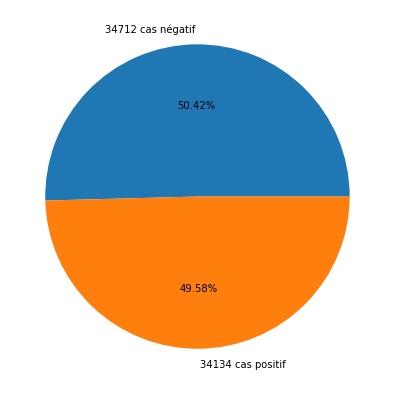

In [16]:
# Répartition du dataset
ze= Y[Y== 0].count() #dfbase["cardio"][dfbase["cardio"]== 0].count()
un= Y[Y== 1].count() #dfbase["cardio"][dfbase["cardio"]== 1].count()
plt.figure(figsize=(7,7))
plt.pie([ze,un], labels= [f"{ze} cas négatif",f"{un} cas positif"], autopct= '%1.2f%%')
plt.show()

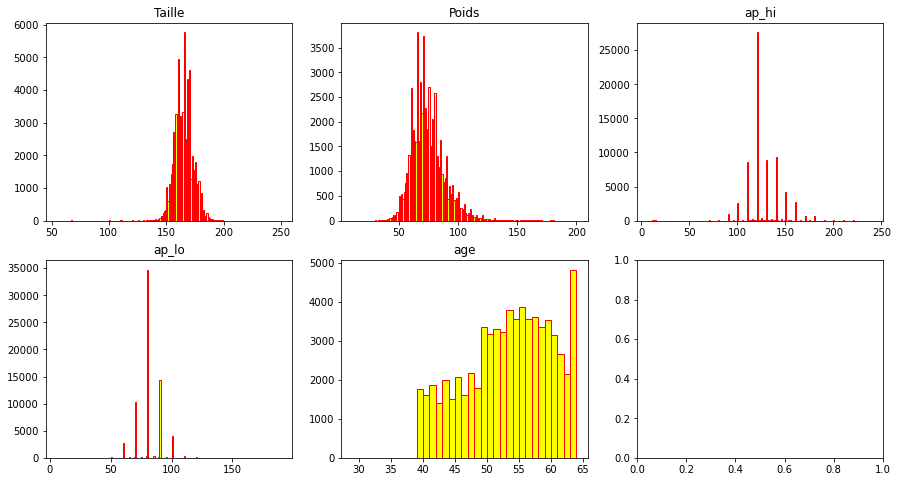

In [17]:
# Affichage des variables quantitatives
fig, ax = plt.subplots(nrows= 2, ncols= 3, figsize= (15,8))

titre= [["Taille", "Poids","ap_hi"], ["ap_lo", "age",""] ]
xt =  [ [np.array(X.height), np.array(X.weight), np.array(X.ap_hi)], [np.array(X.ap_lo),
       (np.array(X.age)/365).astype(int), None] ]

for i in range(0,2):
    for j in range(0,3):
        t= titre[i][j]
        if t == "": break
        
        x= xt[i][j]
        mini= int(x.min())
        maxi= int(x.max())

        ax[i][j].hist(x, range = (mini, maxi), bins = maxi-mini, color = 'yellow',
            edgecolor = 'red')
        ax[i][j].set_title(t)


In [104]:
# Contenu des variables de classification.

for el in ("gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"):
    print(f"Valeur possible de la colonne '{el}': {np.sort(dfbase[el].unique())}")


Valeur possible de la colonne 'gender': [1 2]
Valeur possible de la colonne 'cholesterol': [1 2 3]
Valeur possible de la colonne 'gluc': [1 2 3]
Valeur possible de la colonne 'smoke': [0 1]
Valeur possible de la colonne 'alco': [0 1]
Valeur possible de la colonne 'active': [0 1]
Valeur possible de la colonne 'cardio': [0 1]


In [18]:
# Contenue des variables discrètes
for col in dfbase.select_dtypes("int"):
    print(f"{col:<11}: {np.sort(dfbase[col].unique())}")

age        : [10798 10859 10878 ... 23692 23701 23713]
gender     : [1 2]
height     : [ 55  57  64  65  66  67  68  70  71  72  74  75  76  80  81  91  96  97
  98  99 100 104 105 108 109 110 111 112 117 119 120 122 125 128 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 207 250]
ap_hi      : [  7  10  11  12  13  14  15  16  17  20  24  60  70  80  85  90  93  95
  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 184 185 187 188 190 191
 193 195 196 197 200 202 210 215 22

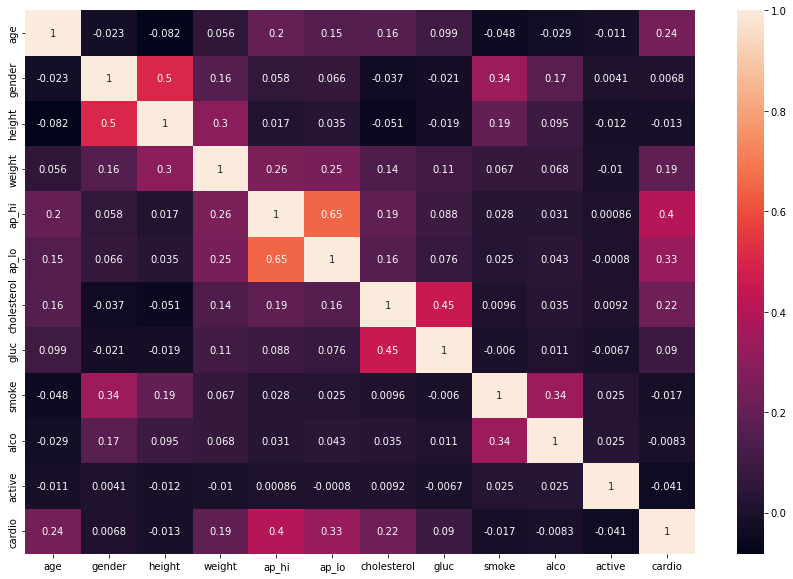

In [19]:



corrMatrix = 
plt.figure(figsize=(15,10))
sn.heatmap(dfbase.corr(), annot=True)
plt.show()


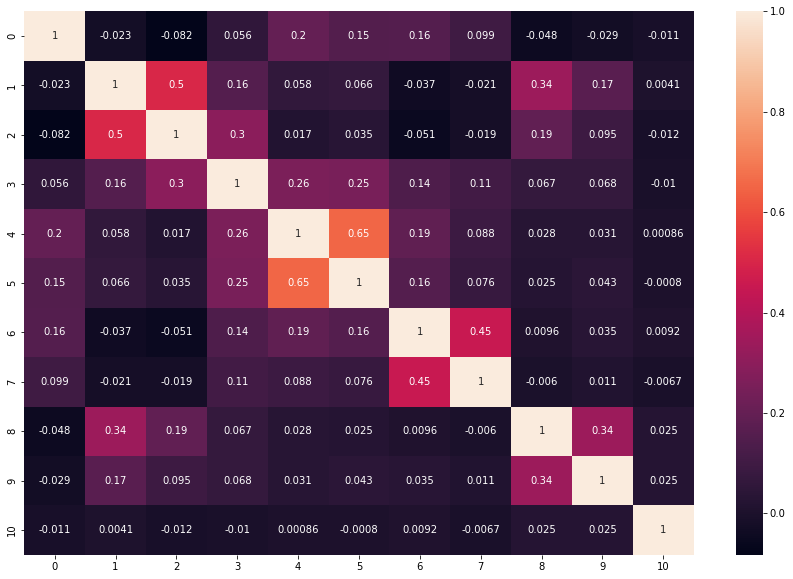

In [22]:
import seaborn as sn

scaler= StandardScaler()

matrice= scaler.fit_transform(X)
mat= pd.DataFrame(matrice)
corrMatrix = mat.corr()
plt.figure(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()


### Analyse en composantes principales
- Sans normalisation
- Normalisation minmax
- Normalisation Standard
- Normalisation Robuste

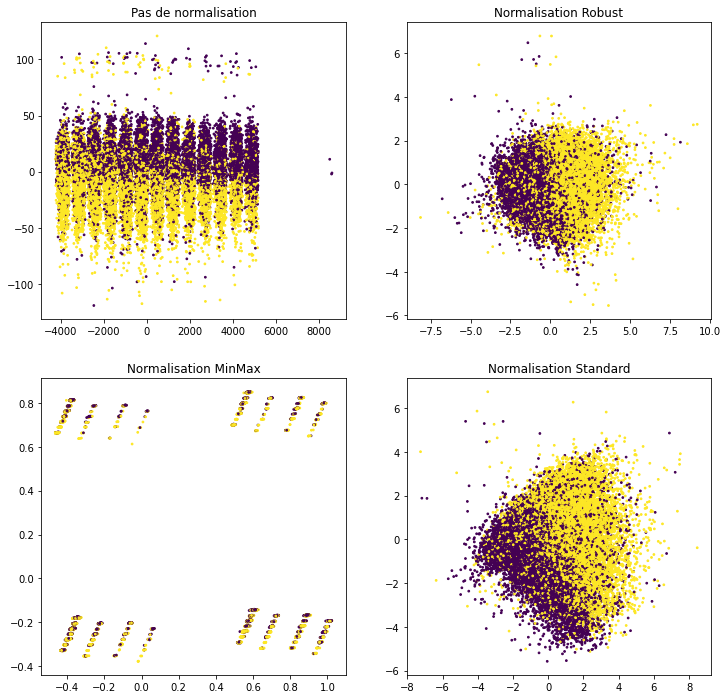

In [6]:
model= PCA(n_components= 2)
X_train_red2= model.fit_transform(X_train)

normalisation= RobustScaler()
X_train_normalise_Robust= normalisation.fit_transform(X_train)
X_train_normalise_Robust_red2= model.fit_transform(X_train_normalise_Robust)

normalisation= MinMaxScaler()
X_train_normalise_MinMax= normalisation.fit_transform(X_train)
X_train_normalise_MinMax_red2= model.fit_transform(X_train_normalise_MinMax)

normalisation= StandardScaler()
X_train_normalise_Standard= normalisation.fit_transform(X_train)
X_train_normalise_Standard_red2= model.fit_transform(X_train_normalise_Standard)


fig, ax = plt.subplots(nrows= 2, ncols= 2, figsize= (12,12))

ax[0][0].scatter(X_train_red2[:,0],X_train_red2[:,1], c=Y_train, s= 3)
ax[0][0].set_title("Pas de normalisation")

ax[0][1].scatter(X_train_normalise_Robust_red2[:,0],X_train_normalise_Robust_red2[:,1], c=Y_train, s= 3)
ax[0][1].set_title("Normalisation Robust")

ax[1][0].scatter(X_train_normalise_MinMax_red2[:,0],X_train_normalise_MinMax_red2[:,1], c=Y_train, s= 3)
ax[1][0].set_title("Normalisation MinMax")

ax[1][1].scatter(X_train_normalise_Standard_red2[:,0],X_train_normalise_Standard_red2[:,1], c=Y_train, s= 3)
ax[1][1].set_title("Normalisation Standard")

_= plt.show()

### Test de différents modèles

In [50]:
for mod in [KNeighborsClassifier(), AdaBoostClassifier(), BaggingClassifier(),
            RandomForestClassifier(), SGDClassifier(), GaussianNB(), BernoulliNB(), SVC()]:
    print(f"Pour le modèle {mod}:")
    for std in [None, StandardScaler(), RobustScaler(), MinMaxScaler()]:
        deb= time.time()
        pre= test_algo(modele= mod, standardisation= std, Xtrain= X_train, Ytrain= Y_train, Xtest= X_test, 
                 Ytest= Y_test)
        fin= time.time()
        if std== None: ecrit= "None"
        else: ecrit= str(std)
        print(f"Standardisation: {ecrit:<15}\tprécision: {100*pre:.2f} %\ttemps d'exécution: {fin-deb:.2f} s")


Pour le modèle KNeighborsClassifier():
Standardisation: None           	précision: 68.25 %	temps d'exécution: 1.30 s
Standardisation: StandardScaler()	précision: 69.47 %	temps d'exécution: 5.69 s
Standardisation: RobustScaler() 	précision: 69.81 %	temps d'exécution: 4.97 s
Standardisation: MinMaxScaler() 	précision: 68.88 %	temps d'exécution: 6.47 s
Pour le modèle AdaBoostClassifier():
Standardisation: None           	précision: 73.11 %	temps d'exécution: 1.51 s
Standardisation: StandardScaler()	précision: 73.11 %	temps d'exécution: 1.47 s
Standardisation: RobustScaler() 	précision: 73.11 %	temps d'exécution: 1.58 s
Standardisation: MinMaxScaler() 	précision: 73.11 %	temps d'exécution: 1.48 s
Pour le modèle BaggingClassifier():
Standardisation: None           	précision: 69.09 %	temps d'exécution: 1.75 s
Standardisation: StandardScaler()	précision: 69.21 %	temps d'exécution: 1.78 s
Standardisation: RobustScaler() 	précision: 68.91 %	temps d'exécution: 1.78 s
Standardisation: MinMaxScal

### Optimisation des différents algorithmes
On utilisera le StandardScaler pour la normalisation des données.

In [7]:
normalisation= StandardScaler()
X_train_normalise= normalisation.fit_transform(X_train)
X_test_normalise= normalisation.transform(X_test)


#### KNeighborsClassifier

In [147]:
param_grid = { "kneighborsclassifier__n_neighbors" : [25, 30, 40],
               "kneighborsclassifier__algorithm" : ["ball_tree"],
               "kneighborsclassifier__weights" : ['uniform']
             }

model= make_pipeline(StandardScaler(),KNeighborsClassifier())

gridkn = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

gridkn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__algorithm': ['ball_tree'],
                         'kneighborsclassifier__n_neighbors': [40],
                         'kneighborsclassifier__weights': ['uniform']})

In [171]:
model_knn= make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors= 35, algorithm= "ball_tree", weights= "uniform"))

model_knn.fit(X_train, Y_train)
prediction = model_knn.predict(X_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= np.array(Y_test))
print(f"{err} erreurs sur {len(X_test)} données soit une précision de {pre:.2f} %")

dump(model_knn, 'modeles/knn35.h5') 

5675 erreurs sur 20654 données soit une précision de 72.52 %


In [155]:
confusion_matrix(Y_test, model_knn.predict(X_test))

array([[8062, 2321],
       [3354, 6917]])

#### RandomForest

In [163]:
param_grid = { "randomforestclassifier__n_estimators" : [200,500,1000],
               "randomforestclassifier__criterion" : ["gini"],
               "randomforestclassifier__max_features": ['auto'], # auto= sqrt
             }

model= make_pipeline(StandardScaler(),RandomForestClassifier())

gridrf = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

gridrf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini'],
                         'randomforestclassifier__max_features': ['auto'],
                         'randomforestclassifier__n_estimators': [200, 500,
                                                                  1000]})

In [172]:
model_rf= make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators= 160, criterion= "gini"))

model_rf.fit(X_train, Y_train)

prediction = model_rf.predict(X_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= np.array(Y_test))
print(f"{err} erreurs sur {len(X_test)} données soit une précision de {pre:.2f} %")

dump(model_rf, 'modeles/rf160.h5')

5953 erreurs sur 20654 données soit une précision de 71.18 %


#### SGDClassifier():
Standardisation: StandardScaler()	précision: 72.14 %	

In [196]:
param_grid = { "sgdclassifier__loss" : ['hinge'],
               "sgdclassifier__penalty" : ['elasticnet'],
               "sgdclassifier__learning_rate" : ['adaptive'],
               "sgdclassifier__eta0": [1,5,10,15]
             }

model= make_pipeline(StandardScaler(),SGDClassifier())

gridsgd = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

gridsgd

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdclassifier', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'sgdclassifier__eta0': [1, 5, 10, 15],
                         'sgdclassifier__learning_rate': ['adaptive'],
                         'sgdclassifier__loss': ['hinge'],
                         'sgdclassifier__penalty': ['elasticnet']})

In [197]:
gridsgd.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdclassifier', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'sgdclassifier__eta0': [1, 5, 10, 15],
                         'sgdclassifier__learning_rate': ['adaptive'],
                         'sgdclassifier__loss': ['hinge'],
                         'sgdclassifier__penalty': ['elasticnet']})

In [198]:
gridsgd.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(eta0=5, learning_rate='adaptive',
                               penalty='elasticnet'))])

In [199]:
gridsgd.best_params_

{'sgdclassifier__eta0': 5,
 'sgdclassifier__learning_rate': 'adaptive',
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__penalty': 'elasticnet'}

In [200]:
gridsgd.best_score_


0.7255146307752616

In [202]:
model_sgd= make_pipeline(StandardScaler(),
                     SGDClassifier(loss= 'hinge', penalty= 'elasticnet', learning_rate= 'adaptive', eta0= 5))

model_sgd.fit(X_train, Y_train)

prediction = model_sgd.predict(X_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= np.array(Y_test))
print(f"{err} erreurs sur {len(X_test)} données soit une précision de {pre:.2f} %")

dump(model_sgd, 'modeles/sgd.h5')

5673 erreurs sur 20654 données soit une précision de 72.53 %


['modeles/sgd.h5']

GaussianNB():
Standardisation: None           	précision: 70.70 %	temps d'exécution: 0.04 s
Standardisation: StandardScaler()	précision: 70.62 %	temps d'exécution: 0.05 s
Standardisation: RobustScaler() 	précision: 70.62 %	temps d'exécution: 0.05 s
Standardisation: MinMaxScaler() 	précision: 70.62 %	temps d'exécution: 0.03 s


In [ ]:
param_grid = { "GaussianNB__" : ['hinge'],
               "GaussianNB__" : ['elasticnet'],
               "GaussianNB__" : ['adaptive'],
               "GaussianNB__": [1,5,10,15]
             }

model= make_pipeline(StandardScaler(),GaussianNB())

gridgs = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

gridgs

In [ ]:
gridgs.fit(X_train, Y_train)

In [ ]:
print(gridsgd.best_estimator_)
print(gridsgd.best_params_)
print(gridsgd.best_score_)

In [206]:
rf= load("modeles/rf160.h5")
knn= load("modeles/knn35.h5")
sgd= load("modeles/sgd.h5")
gs= GaussianNB()
bn= BernoulliNB()


In [218]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

In [220]:
eclf1 = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('sgd', sgd), ('gs',gs), ('bn', bn)], 
                                      voting='hard')
eclf1 = eclf1.fit(X_train, Y_train)
#print(eclf1.predict(X_))

TypeError: __init__() got an unexpected keyword argument 'fin'

In [216]:
eclf1.score(X_test, Y_test)

0.7252832381136826

In [224]:
eclf = StackingClassifier(estimators=[('rf', rf), ('knn', knn), ('sgd', sgd), ('gs',gs), ('bn', bn)], 
                                      final_estimator= RandomForestClassifier())
eclf = eclf.fit(X_train, Y_train)
eclf.score(X_test, Y_test)

0.716519802459572

Pour le modèle BernoulliNB():
Standardisation: None           	précision: 51.89 %	temps d'exécution: 0.03 s
Standardisation: StandardScaler()	précision: 71.24 %	temps d'exécution: 0.07 s
Standardisation: RobustScaler() 	

In [33]:
# On réalise un pipe avec 2 actions: un scaler et un algorithme
pipe = Pipeline(steps= [('scaler', StandardScaler()), ('algo', KNeighborsClassifier())])
#pipe = Pipeline(steps= [(StandardScaler()), ('algo', KNeighborsClassifier())])

# On testera 3 standardisations et pour la régression logistique on testera tout les solvers
param_grid = {'pipeline__scaler': [StandardScaler()],
              'pipeline__algo__n_neighbors': [22,25,30,35],
              'pipeline__algo__algorithm': ['ball_tree'], #, 'ball_tree', 'kd_tree', 'brute'],
              'pipeline__algo__p': [1,2]}

model= make_pipeline(pipe)

grid = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

grid


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('scaler',
                                                         StandardScaler()),
                                                        ('algo',
                                                         KNeighborsClassifier())]))]),
             n_jobs=-1,
             param_grid={'pipeline__algo__algorithm': ['ball_tree'],
                         'pipeline__algo__n_neighbors': [22, 25, 30, 35],
                         'pipeline__algo__p': [1, 2],
                         'pipeline__scaler': [StandardScaler()]})

In [280]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest= train_test_split(dftrain, test_size= 0.2, random_state= 511)

In [281]:
Xtrain.cardio.value_counts(), Xtest.cardio.value_counts()

(0    27711
 1    27365
 Name: cardio, dtype: int64,
 0    7001
 1    6769
 Name: cardio, dtype: int64)

In [213]:
X = dftrain[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active']].values
Y = dftrain['cardio'].values

In [214]:
X,Y

(array([[1.8393e+04, 2.0000e+00, 1.6800e+02, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [2.0228e+04, 1.0000e+00, 1.5600e+02, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [1.8857e+04, 1.0000e+00, 1.6500e+02, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.9066e+04, 2.0000e+00, 1.8300e+02, ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [2.2431e+04, 1.0000e+00, 1.6300e+02, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0540e+04, 1.0000e+00, 1.7000e+02, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]]),
 array([0, 1, 1, ..., 1, 1, 0]))

### A partir de ce data frame on crée les tables examems, patients, médecins ainsi que le dataset qui servira à l'entraînement

#### Création de la base de données qui contiendra toute les tables

# ATTENTION au désiquilibre... regardé si la précision est identique pour les h et pour les femmes

#### Création de la base de données d'entraînement

In [124]:
df2= pd.read_csv("prov.csv")
df2.drop(["Unnamed: 0","id","nom","prenom", "naissance", "nom_med", "prenom_med","idmed","idp","idmed",
          "diag_conf","idexa"], axis= 1, inplace= True)
df2

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69816,19240,2,168,76.0,120,80,1,1,1,0,1,0
69817,22601,1,158,126.0,140,90,2,2,0,0,1,1
69818,19066,2,183,105.0,180,90,3,1,0,1,0,1
69819,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [126]:
df2.to_csv("entrainement.csv", encoding= "utf-8", sep=",", index= False)

In [147]:


try:
    # Création de la base de donnée
    conn = sqlite3.connect('base_E1.db')
    cur = conn.cursor()
    #print("Base de données crée et correctement connectée à SQLite")
    #sql = "SELECT sqlite_version();"
    #cur.execute(sql)
    #res = cur.fetchall()
    #print("La version de SQLite est: ", res)
    
    #df_to_db(curseur= cur, connexion= conn, dataframe= dftest)
    sql = "INSERT INTO entrainement(name, entier, date) VALUES(?,?,?)"
    for i, row in dftest.iterrows():
        cur.execute(sql, tuple(row))
        conn.commit()

    cur.close()
    conn.close()
    print("La connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors de la connexion à SQLite", error)


La connexion SQLite est fermée


In [148]:
for i, row in dftest.iterrows():
    print(i,row)

0 A          toto
B             1
C    2022-04-05
Name: 0, dtype: object
1 A          titi
B             2
C    2022-04-05
Name: 1, dtype: object
2 A          tutu
B             3
C    2022-04-05
Name: 2, dtype: object


In [144]:
dftest

,A,B,C
0,toto,titi,tutu
1,1,2,3
2,2022-04-05,2022-04-05,2022-04-05


In [ ]:
def df_to_db(curseur= None, connexion= None):
    
    # create cursor
    cursor = connection.cursor()

    # Insert DataFrame recrds one by one.
    sql = "INSERT INTO client_info(code,name, nac) VALUES(%s,%s,%s)"
    for i, row in dftest.iterrows():
        cursor.execute(sql, tuple(row))

        # the connection is not autocommitted by default, so we must commit to save our changes
        connection.commit()
    cursor.close()

def insert_into_any_table():
    "a_cursor"
    "a_sql"
    "a_for_loop"
        connection.commit()
    cursor.close()

## Pile all the funciton one after another
insert_into_client_info()
insert_into_any_table()

# close the connection at the end
connection.close()


In [75]:
df2.drop(["id","index","age","height","weight","ap_hi","ap_lo", "gender","cholesterol","gluc","smoke",
          "alco","active","cardio","nom_med","prenom_med", "idmed"],
         axis= 1, inplace= True)

In [108]:
df2

,0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,...,active,cardio,nom,prenom,idp,nom_med,prenom_med,idmed,naissance,diag_conf
0,0,0,18393,2,168,62.0,110,80,1,1,...,1,0,MILANI,mo,1,BREBION,hector,168,1970-03-26 00:00:00,1
1,1,1,20228,1,156,85.0,140,90,3,1,...,1,1,ROUVIERE,achille,2,BRACQ,molly,110,1965-01-22 00:00:00,1
2,2,2,18857,1,165,64.0,130,70,3,1,...,0,1,PAULET,grégoire,3,COUTIER,cerise,154,1968-12-06 00:00:00,1
3,3,3,17623,2,169,82.0,150,100,1,1,...,1,1,OUDART,delta,4,BONVALET,étienne,78,1973-01-10 00:00:00,1
4,4,4,17474,1,156,56.0,100,60,1,1,...,0,0,BACHE,juste,5,PASQUIER,hamilton,96,1972-09-01 00:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69816,69816,99993,19240,2,168,76.0,120,80,1,1,...,1,0,DULIN,lotus,69817,VILLEMAIN,pablo,35,1969-05-14 00:00:00,1
69817,69817,99995,22601,1,158,126.0,140,90,2,2,...,1,1,GARET,hall,69818,PALLIER,cyrille,174,1957-09-26 00:00:00,1
69818,69818,99996,19066,2,183,105.0,180,90,3,1,...,0,1,LAKEHAL,cyrille,69819,ALLIBERT,humphrey,16,1968-05-13 00:00:00,1
69819,69819,99998,22431,1,163,72.0,135,80,1,2,...,0,1,DUREUIL,georges,69820,BESSIERE,ju,25,1960-02-25 00:00:00,1


In [77]:
df2.to_csv("patients.csv")

In [78]:
df2= pd.read_csv("test.csv")
df2.drop(["id","index","age","height","weight","ap_hi","ap_lo", "gender","cholesterol","gluc","smoke",
          "alco","active","cardio","nom","prenom", "idp", "naissance"],
         axis= 1, inplace= True)
df2

,nom_med,prenom_med,idmed,naissance
0,BREBION,hector,168,1970-03-26 00:00:00
1,BRACQ,molly,110,1965-01-22 00:00:00
2,COUTIER,cerise,154,1968-12-06 00:00:00
3,BONVALET,étienne,78,1973-01-10 00:00:00
4,PASQUIER,hamilton,96,1972-09-01 00:00:00
...,...,...,...,...
69816,VILLEMAIN,pablo,35,1969-05-14 00:00:00
69817,PALLIER,cyrille,174,1957-09-26 00:00:00
69818,ALLIBERT,humphrey,16,1968-05-13 00:00:00
69819,BESSIERE,ju,25,1960-02-25 00:00:00


In [80]:
df2.to_csv("medecins.csv")

In [89]:
df2= pd.read_csv("test.csv")

In [90]:
df2.drop(["id","index","nom","prenom", "naissance", "nom_med", "prenom_med","idmed","idp"],
         axis= 1, inplace= True)
df2

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69816,19240,2,168,76.0,120,80,1,1,1,0,1,0
69817,22601,1,158,126.0,140,90,2,2,0,0,1,1
69818,19066,2,183,105.0,180,90,3,1,0,1,0,1
69819,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [91]:
#df2.rename(columns={"idp":"id"}, inplace= True)
df2.to_csv("entrainement.csv")

In [15]:
from datetime import timedelta, date
import datetime

In [29]:
delta= timedelta(days=365)
delta


DatetimeIndex(['1970-01-01 00:00:00.000001965',
               '1970-01-01 00:00:00.000000011',
               '1970-01-01 00:00:00.000000005'],
              dtype='datetime64[ns]', freq=None)

In [20]:
datetime.datetime(1,1,10)

datetime.datetime(1, 1, 10, 0, 0)

In [50]:
df["naissance"]= None
for idx, row in df.iterrows():
    ecart= random.randint(10,1000)
    age= int(df.loc[idx,"age"])
    dt= date.today()-timedelta(days= age + ecart)
    df.loc[idx,"naissance"]= pd.to_datetime(dt)
df

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,...,alco,active,cardio,nom,prenom,idp,nom_med,prenom_med,idmed,naissance
0,0,0,18393,2,168,62.0,110,80,1,1,...,0,1,0,MILANI,mo,1,BREBION,hector,168,1970-03-26 00:00:00
1,1,1,20228,1,156,85.0,140,90,3,1,...,0,1,1,ROUVIERE,achille,2,BRACQ,molly,110,1965-01-22 00:00:00
2,2,2,18857,1,165,64.0,130,70,3,1,...,0,0,1,PAULET,grégoire,3,COUTIER,cerise,154,1968-12-06 00:00:00
3,3,3,17623,2,169,82.0,150,100,1,1,...,0,1,1,OUDART,delta,4,BONVALET,étienne,78,1973-01-10 00:00:00
4,4,4,17474,1,156,56.0,100,60,1,1,...,0,0,0,BACHE,juste,5,PASQUIER,hamilton,96,1972-09-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69816,69816,99993,19240,2,168,76.0,120,80,1,1,...,0,1,0,DULIN,lotus,69817,VILLEMAIN,pablo,35,1969-05-14 00:00:00
69817,69817,99995,22601,1,158,126.0,140,90,2,2,...,0,1,1,GARET,hall,69818,PALLIER,cyrille,174,1957-09-26 00:00:00
69818,69818,99996,19066,2,183,105.0,180,90,3,1,...,1,0,1,LAKEHAL,cyrille,69819,ALLIBERT,humphrey,16,1968-05-13 00:00:00
69819,69819,99998,22431,1,163,72.0,135,80,1,2,...,0,0,1,DUREUIL,georges,69820,BESSIERE,ju,25,1960-02-25 00:00:00


In [51]:
df.to_csv("test.csv", encoding= "utf-8", sep=",")

In [36]:
pd.to_datetime(0)

Timestamp('1970-01-01 00:00:00')

In [81]:
df[df.nom== "MAFFRE"]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,nom,prenom,idp,nom_med,prenom_med,idmed
13252,18944,19721,1,170,73.0,120,80,1,1,0,0,0,1,MAFFRE,turin,13253,ALLIBERT,humphrey,16
20331,29086,16091,1,151,64.0,110,80,1,1,0,0,0,0,MAFFRE,amar,20332,SANTAMARIA,france,50
32775,46936,21944,2,171,68.0,120,80,1,1,1,0,1,0,MAFFRE,marcia,32776,SIRI,dom,142
33053,47349,18829,1,154,72.0,140,100,2,1,0,0,1,1,MAFFRE,antoine,33054,BASSOT,carla,120
38364,54912,21291,2,175,110.0,140,90,1,1,0,0,1,1,MAFFRE,laura,38365,BONVARLET,bruno,157
51640,73837,22003,1,160,60.0,150,100,3,1,0,0,0,1,MAFFRE,spencer,51641,NERON,platon,128
66646,95407,21825,1,156,70.0,150,80,2,1,0,0,1,1,MAFFRE,francis,66647,PASTORE,sylvia,130
66847,95681,19606,1,156,53.0,140,90,3,1,0,0,1,0,MAFFRE,giorgio,66848,BOCHATON,ah,163


In [36]:
# La matrice d'Inès :)
matrice_corr = df.corr(method='spearman').style.format("{:.3}").background_gradient(cmap=plt.get_cmap('coolwarm'))
matrice_corr

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.0,0.0025,0.00351,-0.00187,-0.00111,0.00322,-0.000266,0.00581,0.00259,-0.00369,0.00106,0.00369,0.00369
age,0.0025,1.0,-0.0205,-0.0824,0.0618,0.219,0.157,0.14,0.0917,-0.0476,-0.0305,-0.0107,0.235
gender,0.00351,-0.0205,1.0,0.534,0.174,0.0635,0.0665,-0.0356,-0.0187,0.338,0.171,0.00445,0.00746
height,-0.00187,-0.0824,0.534,1.0,0.316,0.0192,0.03,-0.0591,-0.0242,0.198,0.0967,-0.0098,-0.0137
weight,-0.00111,0.0618,0.174,0.316,1.0,0.279,0.255,0.138,0.109,0.072,0.0684,-0.0104,0.185
ap_hi,0.00322,0.219,0.0635,0.0192,0.279,1.0,0.738,0.209,0.105,0.0293,0.0331,-0.00127,0.453
ap_lo,-0.000266,0.157,0.0665,0.03,0.255,0.738,1.0,0.168,0.0824,0.0261,0.0388,0.00337,0.363
cholesterol,0.00581,0.14,-0.0356,-0.0591,0.138,0.209,0.168,1.0,0.408,0.015,0.0409,0.00778,0.216
gluc,0.00259,0.0917,-0.0187,-0.0242,0.109,0.105,0.0824,0.408,1.0,0.000246,0.0183,-0.00737,0.0922
smoke,-0.00369,-0.0476,0.338,0.198,0.072,0.0293,0.0261,0.015,0.000246,1.0,0.34,0.0256,-0.0156


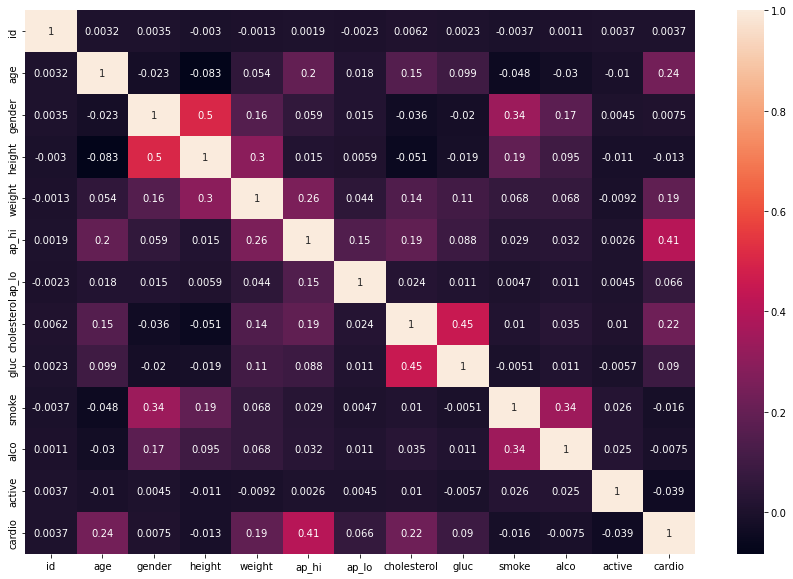

In [39]:
import seaborn as sn

corrMatrix = df.corr()
plt.figure(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()
